In [1]:
from UTILITY_quickstart import *  


tao = initializeTao(     
    loadDefaultLatticeTF = False
)


Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Not using setLattice(). Golden lattice
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/beams/activeBeamFile.h5, and reinit to tao


In [2]:
totalNumElements = len(tao.lat_list("*", "ele.name"))

combinedElementData = [
    {
        "eleII" : eleII,
        "name" : tao.ele_head(eleII)["name"],
        "key" : tao.ele_head(eleII)["key"],
        "s" : tao.ele_head(eleII)["s"]
    }
    for eleII in range(totalNumElements) 
]

#Keep only elements after L0AFEND
combinedElementData = [ele for ele in combinedElementData if ele["s"] > 4.1274477]

allHKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "HKicker"]
allVKickerNames = [ele["name"] for ele in combinedElementData if ele["key"] == "VKicker"]

#Manually picking a list of elements that seem like BPMs. Fast and dirty, DNT
#[ele["name"] for ele in combinedElementData if ele["key"] == "Monitor"]
allBPMNames = ['BPM10371', 'BPM10425', 'BPM10511', 'BPM10525',  'BPM10581', 'BPM10631', 'BPM10651', 'BPM10731', 'BPM10771', 'BPM10781', 'BPM11132', 'BPM11201', 'BPM11265', 'BPM11301', 'BPM11312', 'BPM11333', 'BPM11358', 'BPM11362', 'BPM11393', 'BPM11401', 'BPM11501', 'BPM11601', 'BPM11701', 'BPM11801', 'BPM11901', 'BPM12201', 'BPM12301', 'BPM12401', 'BPM12501', 'BPM12601', 'BPM12701', 'BPM12801', 'BPM12901', 'BPM13201', 'BPM13301', 'BPM13401', 'BPM13501', 'BPM13601', 'BPM13701', 'BPM13801', 'BPM13901', 'BPM14201', 'BPM14301', 'BPM14401', 'BPM14501', 'BPM14601', 'BPM14701', 'BPM14715', 'BPM14801', 'BPM14891', 'BPM14901', 'BPM15201', 'BPM15301', 'BPM15401', 'BPM15501', 'BPM15601', 'BPM15701', 'BPM15801', 'BPM15901', 'BPM16201', 'BPM16301', 'BPM16401', 'BPM16501', 'BPM16601', 'BPM16701', 'BPM16801', 'BPM16901', 'BPM17201', 'BPM17301', 'BPM17401', 'BPM17501', 'BPM17601', 'BPM17701', 'BPM17801', 'BPM17901', 'BPM18201', 'BPM18301', 'BPM18401', 'BPM18501', 'BPM18601', 'BPM18701', 'BPM18801', 'BPM18901', 'BL18900', 'BPM19201', 'BPM19301', 'BPM19401', 'BPM19801', 'BPM19851', 'BPM19871', 'M1E', 'M3E', 'MS2EL', 'M4E', 'M5E', 'M6E', 'M7E', 'M8E', 'MS2ER', 'M9E', 'M11E', 'M1FF', 'M2FF', 'M3FF', 'M4FF', 'M5FF', 'M0EX', 'M1EX', 'M2EX', 'M3EX']



## An aside on coordinates

In [3]:
# print( tao.ele_orbit("BEGBC20") )
# print( tao.ele_floor("BEGBC20") )
# tao.cmd("set ele BEGBC20 X_OFFSET = 0.001")
# print( tao.ele_orbit("BEGBC20") )
# print( tao.ele_floor("BEGBC20") )

# tao.cmd("show ele BEGBC20 -all")

In [4]:
# tao.cmd("show ele Q6E -all")

In [5]:
# print( tao.ele_orbit("Q6E") )
# print( tao.ele_floor("Q6E") )
# tao.cmd("set ele Q6E X_OFFSET = 0.001")
# print( tao.ele_orbit("Q6E") )
# print( tao.ele_floor("Q6E") )

# tao.cmd("show ele Q6E -all")

In [6]:
tao.ele_orbit("Q6E")["x"] - (tao.ele_floor("Q6E")["Actual"][0] - tao.ele_floor("Q6E")["Reference"][0])

8.77002062190664e-16

## Develop optimizer

In [7]:
from scipy.optimize import minimize

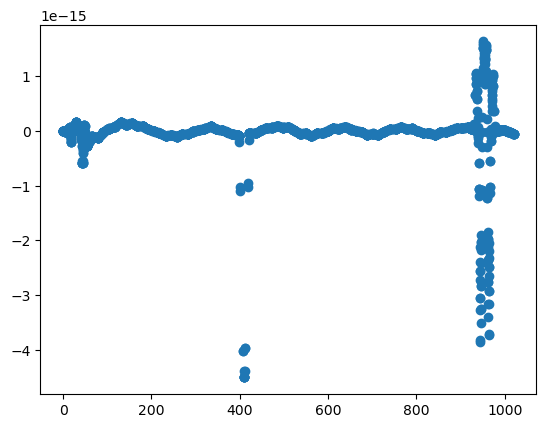

In [8]:
plt.scatter(
    [ tao.ele_head(eleII)["s"] for eleII in range(totalNumElements) ],
    [ tao.ele_orbit(eleII)["x"] for eleII in range(totalNumElements) ]
)

In [9]:
#Perturb something just to check effect
tao.cmd(f"set ele Q11801 X_OFFSET = 0.001")
tao.cmd(f"set ele Q11801 Y_OFFSET = 0.0007")

[]

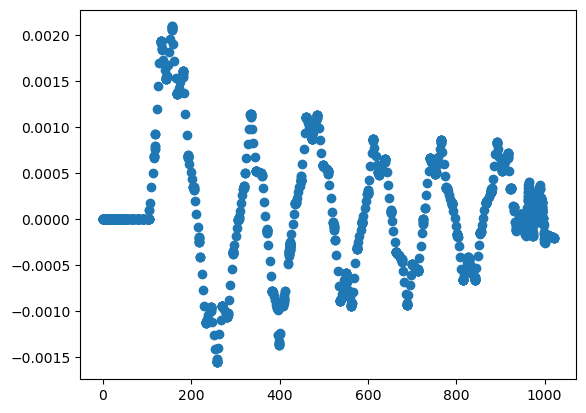

In [10]:
plt.scatter(
    [ tao.ele_head(eleII)["s"] for eleII in range(totalNumElements) ],
    [ tao.ele_orbit(eleII)["x"] for eleII in range(totalNumElements) ]
)

In [11]:
def xSetter(tao, params):
    #Prevent recalculation until changes are made
    tao.cmd("set global lattice_calc_on = F")
    
    for eleII in range(len(allHKickerNames)):
        setKickerkG(tao, allHKickerNames[eleII], params[eleII])
    
    #Reenable lattice calculations
    tao.cmd("set global lattice_calc_on = T")

def xObjective(params, tao):
    
    try:
        xSetter(tao, params)
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20


    orbitError = np.sqrt( np.mean( np.array([ tao.ele_orbit(ele)["x"] - (tao.ele_floor(ele)["Actual"][0] - tao.ele_floor(ele)["Reference"][0]) for ele in allBPMNames ]) ** 2 ) )

    #Optionally give a very slight preference to solutions that don't move the magnets very much
    moveError = 1e-6 * np.sum( (params) ** 2 ) 

    
    #print(orbitError, moveError, orbitError + moveError )
    
    return orbitError + moveError

def xSolver(tao):

    bounds = [ (-0.1, 0.1) for ele in allHKickerNames ] 
    initialGuess = [ 0 for ele in allHKickerNames ] 

    #Yes, I know there are far better ways to do this. No, I don't care.
    result = minimize(
        xObjective, 
        initialGuess, 
        #method='Nelder-Mead',
        method = "L-BFGS-B",
        bounds = bounds,
        args = (tao,)
    )

    
    return result

result = xSolver(tao)

print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



Optimization Results:
Optimal Parameters: [-9.35895999e-06  7.97963846e-05 -2.09052965e-05  4.25852615e-05
 -5.80272296e-06  8.49958030e-07 -1.75090837e-05  1.46366734e-05
 -1.62180146e-05  3.06236939e-06  5.97950807e-06 -2.32056792e-06
 -1.06048477e-05 -4.06994330e-08  4.94125411e-05 -9.04790847e-05
  1.62677645e-04  1.71483772e-03  3.09358850e-04 -1.52411392e-04
  2.06581632e-06  6.18804940e-05  2.08962374e-05 -1.74649709e-05
 -2.52765787e-05 -1.45276313e-06 -4.66805416e-06  3.08977119e-05
  1.46436465e-05  4.87323918e-06 -5.31224670e-06 -1.40389499e-05
 -4.48235561e-06  2.96926278e-06  7.46062204e-06  1.89450549e-05
  3.34013838e-06 -8.56404932e-06 -9.33090821e-06 -1.37871601e-05
 -8.93176266e-06  1.59613518e-06  1.89377277e-06 -9.49173933e-07
 -4.94123845e-06 -4.51600311e-06 -6.08074063e-06 -2.45051632e-06
 -6.24706447e-07  1.90682789e-06  7.45046154e-06  3.12796400e-06
  1.79673715e-06 -1.40877405e-06 -5.50688859e-06 -3.64103337e-06
 -5.09039233e-06 -1.07179621e-06  3.26668871e-06

In [12]:
xSetter(tao, result.x)

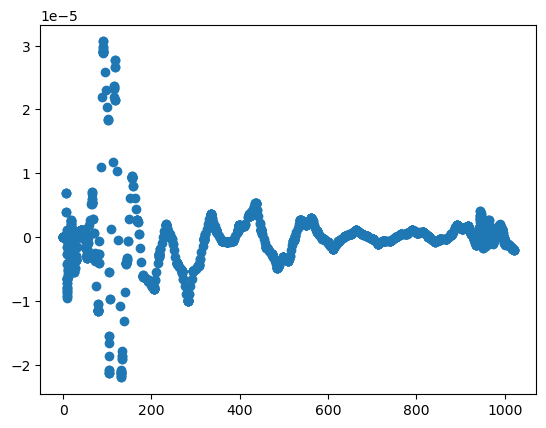

In [13]:
plt.scatter(
    [ tao.ele_head(eleII)["s"] for eleII in range(1700) ],
    [ tao.ele_orbit(eleII)["x"] for eleII in range(1700) ]
)

In [14]:
def ySetter(tao, params):
    #Prevent recalculation until changes are made
    tao.cmd("set global lattice_calc_on = F")
    
    for eleII in range(len(allVKickerNames)):
        setKickerkG(tao, allVKickerNames[eleII], params[eleII])
    
    #Reenable lattice calculations
    tao.cmd("set global lattice_calc_on = T")

def yObjective(params, tao):
    
    try:
        ySetter(tao, params)
    
    except: #If Bmad doesn't like the proposed solution, don't crash, give a bad number
        return 1e20


    orbitError = np.sqrt( np.mean( np.array([ tao.ele_orbit(ele)["y"] - (tao.ele_floor(ele)["Actual"][1] - tao.ele_floor(ele)["Reference"][1]) for ele in allBPMNames ]) ** 2 ) )

    #Optionally give a very slight preference to solutions that don't move the magnets very much
    moveError = 1e-6 * np.sum( (params) ** 2 ) 

    
    #print(orbitError, moveError, orbitError + moveError )
    
    return orbitError + moveError

def ySolver(tao):

    bounds = [ (-0.1, 0.1) for ele in allHKickerNames ] 
    initialGuess = [ 0 for ele in allHKickerNames ] 

    #Yes, I know there are far better ways to do this. No, I don't care.
    result = minimize(
        yObjective, 
        initialGuess, 
        #method='Nelder-Mead',
        method = "L-BFGS-B",
        bounds = bounds,
        args = (tao,)
    )

    
    return result

result = ySolver(tao)

print("Optimization Results:")
print(f"Optimal Parameters: {result.x}")
print(f"Objective Function Value at Optimal Parameters: {result.fun}")
print(f"Number of Iterations: {result.nit}")
print(f"Converged: {result.success}")



Optimization Results:
Optimal Parameters: [-7.69112829e-07 -1.91495612e-06 -3.18611585e-06  1.16734888e-06
 -2.64094197e-06  8.90783188e-06 -2.07410795e-06 -5.46164810e-06
  3.94397373e-06  9.22532527e-06 -1.61316920e-06 -2.59793770e-06
 -6.52810591e-07  6.40428530e-07 -1.78941430e-06  4.55387653e-06
 -3.22617821e-05  1.32332471e-04 -8.42058862e-05 -1.36784492e-03
  1.21787329e-04  1.34475435e-04 -4.64136240e-05 -4.10302759e-05
  1.26378285e-06  2.03813694e-05  2.01599620e-05  1.10275855e-06
 -2.56236490e-05 -5.12051715e-06  1.53594980e-06  7.03072985e-06
  1.11625705e-05  1.98225739e-06 -6.44087540e-06 -6.62249910e-06
 -1.00323204e-05  7.10026798e-07  7.18810025e-06  3.70214869e-06
  2.39666759e-06 -2.51891566e-07 -8.15198208e-06 -3.82291091e-06
 -5.22333830e-06 -1.43738495e-06  4.69668537e-07  2.08022450e-07
 -2.28261282e-07 -1.20299624e-06 -3.31333011e-06 -2.47819291e-06
 -3.88079240e-06  4.61540835e-07  3.51326201e-06  2.88762464e-06
  4.11525944e-06  1.17564248e-06 -7.30997952e-07

In [15]:
ySetter(tao, result.x)

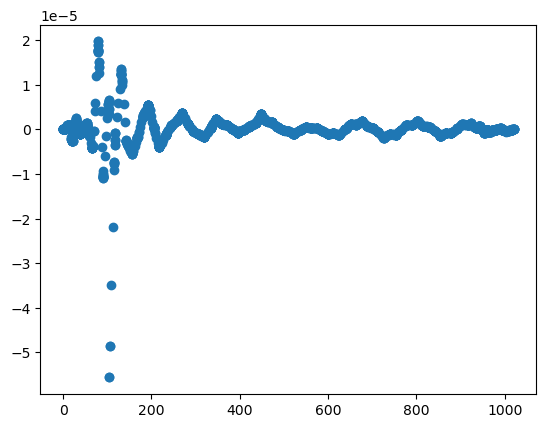

In [16]:
plt.scatter(
    [ tao.ele_head(eleII)["s"] for eleII in range(1700) ],
    [ tao.ele_orbit(eleII)["y"] for eleII in range(1700) ]
)